In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import sklearn

from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn import FunctionSampler  # to use a idendity sampler

from pandas.api.types import CategoricalDtype

In [2]:
np.random.seed(0)
IMPUTATION_REQUIRED=0
TRAIN_SIZE=0.8
PAR_NORMALIZE=0
PAR_SCALE=1
target_col = 'lrecon' # 'lrgen', 'lrecon', 'galtan'
target_factor = target_col + '_factor' # 'lrgen_factor', 'lrecon_factor', 'galtan_factor'
# check if data is imputed or not
IMPUTED_DATA = 'No' # 'Yes' if imputed
SOURCE_DATA_FILES = 'data/base_data/recategorized_4l3c4r/' #'data/imputed_data/recategorized/imputation_cart/'
FILE_SUFFIX = '_recategorized'

In [3]:
#data_raw = pd.read_csv("data/CHES2019_experts_imputed_cart.csv", index_col=0).reset_index(drop=True)
data_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_train' + FILE_SUFFIX + '.csv', index_col = 0)
data_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_train' + FILE_SUFFIX + '.csv', index_col = 0)
if IMPUTED_DATA == 'Yes':
    valid_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_valid' + FILE_SUFFIX + '.csv', index_col = 0)
    valid_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_valid' + FILE_SUFFIX + '.csv', index_col = 0)
test_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_test' + FILE_SUFFIX + '.csv', index_col = 0)
test_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_test' + FILE_SUFFIX + '.csv', index_col = 0)
#data = pd.read_csv("data/CHES2019_experts_imputed_pmm.csv")

# Data preprocessing
Preprocessing steps (after imputation in R)

In [4]:
# split data into training and test dataset
# split data for obtaining a separated TEST dataset (not used for training)
X_train = data_X
X_test = test_X
y_train = data_y
y_test = test_y

In [5]:
# standardization/normalization of data
# Be aware: information related to scaling MUST NOT flow into the separated datasets
# --> 1st split, 2nd scaling
if (PAR_NORMALIZE==1):
    data_normalized = preprocessing.normalize(X_train)

if (PAR_SCALE==1):
    scaler = preprocessing.StandardScaler().fit(X_train)
    data_scaled = scaler.transform(X_train)

In [6]:
X_train_base = X_train
y_train_base = y_train

# Oversampling to balance the dataset regarding target variable

In [7]:
#samplers = [
#    FunctionSampler(),
#    RandomOverSampler(random_state=0),
#    SMOTE(random_state=0),
#    ADASYN(random_state=0),
#]


#X_train, y_train = RandomOverSampler(random_state=0).fit_resample(X_train_base, y_train_base)
X_train, y_train = SMOTE(random_state=0, sampling_strategy='not majority').fit_resample(X_train_base, y_train_base)
#X_train, y_train = ADASYN(random_state=0, sampling_strategy='minority').fit_resample(X_train_base, y_train_base)


#for sampler in samplers:
#    sampler.fit_resample(X_train, y_train)




In [8]:
y_train.value_counts()

lrecon_factor
c                977
l                977
r                977
dtype: int64

# Principal Component Analysis: reduce dimensionality

In [9]:
# create a PCA with 2 components
# combine the result with the target result
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 
                                        'PC2'],
                          index=X_train.index)
finalDf = pd.concat([principalDf, y_train], axis = 1)


In [10]:
finalDf[target_factor].factorize()[0]

array([0, 1, 1, ..., 1, 1, 1])

In [11]:
finalDf.head()

,PC1,PC2,lrecon_factor
0,-6.286693,0.540080,c
1,0.242622,7.432075,r
2,-4.087886,3.138031,r
3,1.611035,0.475821,r
4,10.339833,2.759254,r


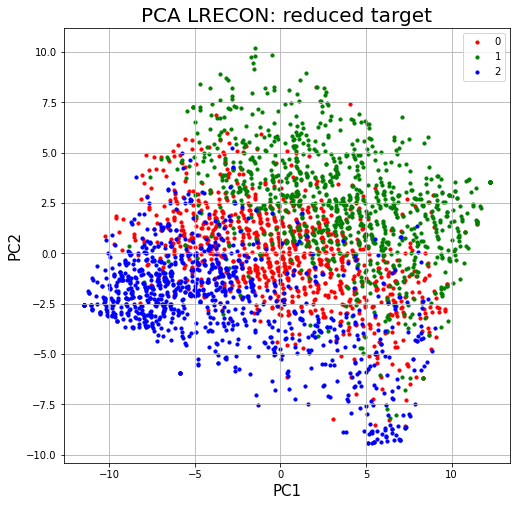

In [12]:
# visualize the results of the PCA
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA LRECON: reduced target', fontsize = 20)

targets = range(0,3)
colors = ['r', 'g', 'b']#, 'c',  'm',  'y',  'k',  'gray',  'lime',  'orange',  'gold']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[target_factor].factorize()[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

In [13]:
# about 80% of the variance are explained through the 2 components
pca.explained_variance_ratio_

array([0.60089784, 0.21240793])

# Clustering
Check if some patterns can be observed using unsupervised learning

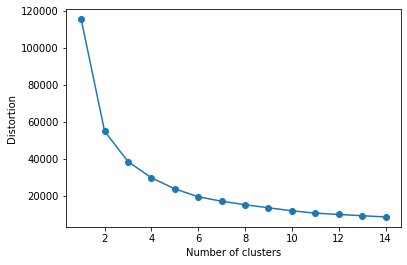

In [14]:
# try to obtain best number of clusters through scree plot
distortions = []
for i in range(1, 15):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(finalDf[['PC1', 'PC2']])
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [15]:
# try to cluster results of PCA
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(finalDf[['PC1', 'PC2']])

In [16]:
y_km

array([0, 1, 1, ..., 1, 1, 2], dtype=int32)

In [17]:
cluster_data = pd.concat([finalDf, 
                          pd.DataFrame(y_km, 
                                       index=X_train.index, 
                                       columns=['cluster'])], 
                         axis=1)

In [18]:
cluster_data.head(20)
#cluster_data[cluster_data['lrgen_factor']==10]['cluster'].value_counts()

,PC1,PC2,lrecon_factor,cluster
0,-6.286693,0.540080,c,0
1,0.242622,7.432075,r,1
2,-4.087886,3.138031,r,1
3,1.611035,0.475821,r,1
4,10.339833,2.759254,r,2
5,-6.644463,1.687372,c,0
6,9.217636,0.704407,r,2
7,-1.168248,-0.041835,r,1
8,2.157659,-3.594523,l,3
9,-0.884202,0.427257,c,1


In [19]:
cluster_data.pivot_table(aggfunc='count', columns = [target_factor, 'cluster']).T

PC1  PC2
lrecon_factor cluster          
c             0        216  216
              1        426  426
              2        124  124
              3        211  211
l             0        663  663
              1         72   72
              2         16   16
              3        226  226
r             0         23   23
              1        435  435
              2        450  450
              3         69   69

# Supervised learning: various algorithms
### Sources: https://vitalflux.com/grid-search-explained-python-sklearn-examples/

## 1) Support Vector Classification

CHECK: RMSE and other scoring mechanisms

In [20]:
########### PARAMETERS 
scoring_method = 'balanced_accuracy'#['balanced_accuracy', 'f1_samples', 'roc_auc_ovo_weighted']
cv_nr = 5

In [21]:
# CROSS-VALIDATION (without TEST dataset)

clf = SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X_train, np.ravel(y_train), cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.76320273 0.70648464 0.7337884  0.74573379 0.76791809]
0.74 accuracy with a standard deviation of 0.02


In [22]:
pipelineSVC = make_pipeline(StandardScaler(), SVC(random_state=1))
# Create the parameter grid
param_grid_svc = [{
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['linear'],
                    'svc__degree': [1,2,3,4,5]
                  },
                 {
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['rbf']
                 }]
# Create an instance of GridSearch Cross-validation estimator
gsSVC = GridSearchCV(estimator=pipelineSVC,
                     param_grid = param_grid_svc,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the SVM classifier
gsSVC.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsSVC.best_score_)
# Print the model parameters of the best model
print(gsSVC.best_params_)
# Print the model score on the test data using GridSearchCV score method
print('Test accuracy: %.3f' % gsSVC.score(X_test, y_test))
# Print the model score on the test data using Best estimator instance
clfSVC = gsSVC.best_estimator_
#print('Test accuracy: %.3f' % clfSVC.score(X_test, y_test))

0.7594714809000523
{'svc__C': 10.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Test accuracy: 0.785


## Random Forest Classification

In [23]:
pipelineRFC = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1, criterion='entropy')) 
# Create the parameter grid
                            
param_grid_rfc = [{
    'randomforestclassifier__max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],
    'randomforestclassifier__max_features':[2, 3, 4, 5, 6],
    'randomforestclassifier__n_estimators':range(5, 105, 5)#,
    #'randomforestclassifier__criterion:':['gini', 'entropy']
}]
# Create an instance of GridSearch Cross-validation estimator
gsRFC = GridSearchCV(estimator=pipelineRFC,
                     param_grid = param_grid_rfc,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the RandomForestClassifier
gsRFC = gsRFC.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsRFC.best_score_)
# Print the model parameters of the best model
print(gsRFC.best_params_)
# Print the test score of the best model
clfRFC = gsRFC.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(X_test, y_test))

0.7645630559916274
{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 2, 'randomforestclassifier__n_estimators': 95}
Test accuracy: 0.767


In [24]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

## Logistic Regression Classification

In [25]:
pipelineLR = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, penalty='l2', solver='lbfgs'))
# Create the parameter grid
param_grid_lr = [{
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
}]
# Create an instance of GridSearch Cross-validation estimator
gsLR = GridSearchCV(estimator=pipelineLR,
                     param_grid = param_grid_lr,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the LogisticRegression Classifier
gsLR = gsLR.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsLR.best_score_)
# Print the model parameters of the best model
print(gsLR.best_params_)
# Print the test score of the best model
clfLR = gsLR.best_estimator_
print('Test accuracy: %.3f' % clfLR.score(X_test, y_test))

0.7410343624629339
{'logisticregression__C': 0.5}
Test accuracy: 0.757


## ADABoost Classification (Ensemble Method)

In [26]:
pipelineADAB = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=1))
# Create the parameter grid
param_grid_ADAB = [{
    'adaboostclassifier__n_estimators': [2, 10, 20, 30, 40, 50, 100]
}]
# Create an instance of GridSearch Cross-validation estimator
gsADAB = GridSearchCV(estimator=pipelineADAB,
                     param_grid = param_grid_ADAB,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the LogisticRegression Classifier
gsADAB = gsADAB.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsADAB.best_score_)
# Print the model parameters of the best model
print(gsADAB.best_params_)
# Print the test score of the best model
clfADAB = gsADAB.best_estimator_
print('Test accuracy: %.3f' % clfADAB.score(X_test, y_test))

0.7424140938426653
{'adaboostclassifier__n_estimators': 40}
Test accuracy: 0.743


In [27]:
gsADAB.scoring

'balanced_accuracy'

# Test models with independent dataset

In [28]:
#scaler = preprocessing.StandardScaler().fit(test_X)
#test_X_scaled = scaler.transform(test_X)

In [29]:
sklearn.metrics.accuracy_score(test_y, gsADAB.predict(test_X))

0.7430555555555556

In [30]:
sklearn.metrics.confusion_matrix(test_y, gsADAB.predict(test_X))

array([[78, 20, 22],
       [12, 74,  2],
       [17,  1, 62]])

In [31]:
#sklearn.metrics.mean_squared_error(test_y, gsADAB.predict(test_X))

In [32]:
sklearn.metrics.f1_score(test_y, gsADAB.predict(test_X), average='weighted')

0.7409562340420314

In [33]:
sklearn.metrics.accuracy_score(test_y, gsLR.predict(test_X))

0.7569444444444444

In [34]:
sklearn.metrics.confusion_matrix(test_y, gsLR.predict(test_X))

array([[83, 20, 17],
       [13, 74,  1],
       [18,  1, 61]])

In [35]:
#sklearn.metrics.mean_squared_error(test_y, gsLR.predict(test_X))

In [36]:
sklearn.metrics.f1_score(test_y, gsLR.predict(test_X), average='weighted')

0.755837679979344

In [37]:
sklearn.metrics.accuracy_score(test_y, gsRFC.predict(test_X))

0.7673611111111112

In [38]:
sklearn.metrics.confusion_matrix(test_y, gsRFC.predict(test_X))

array([[85, 15, 20],
       [11, 77,  0],
       [19,  2, 59]])

In [39]:
#sklearn.metrics.mean_squared_error(test_y, gsRFC.predict(test_X))

In [40]:
sklearn.metrics.f1_score(test_y, gsRFC.predict(test_X), average='weighted')

0.7661149940355079

In [41]:
sklearn.metrics.accuracy_score(test_y, gsSVC.predict(test_X))

0.7777777777777778

In [42]:
sklearn.metrics.confusion_matrix(test_y, gsSVC.predict(test_X))

array([[86, 14, 20],
       [10, 76,  2],
       [17,  1, 62]])

In [43]:
#sklearn.metrics.mean_squared_error(test_y, gsSVC.predict(test_X))

In [44]:
sklearn.metrics.f1_score(test_y, gsSVC.predict(test_X), average='weighted')

0.7770755307236579

In [45]:
#pipeline = Pipeline(steps=[("preprocesser", preprocessor), ("classifier", LogisticRegression())])
#pipeline.fit(X_train, y_train)

In [46]:
#pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

In [47]:
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
#pipe.fit(X_train, y_train)
#Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])
#pipe.score(X_test, y_test)

In [48]:
### Write several scores to the output ###

RMSE = False
model_vector = [gsADAB, gsLR, gsRFC, gsSVC]
for model in model_vector:
    print(model.estimator.named_steps)
    print('Accuracy Score: ', sklearn.metrics.accuracy_score(test_y, model.predict(test_X)))
    print('Balanced Accuracy Score: ', sklearn.metrics.balanced_accuracy_score(test_y, model.predict(test_X)))
    print('Cohen-Kappa-Score: ', sklearn.metrics.cohen_kappa_score(test_y, model.predict(test_X)))
    print('F1-Score: ', sklearn.metrics.f1_score(test_y, model.predict(test_X), average='weighted'))
    if RMSE == True:
        print('RMSE: ', sklearn.metrics.mean_squared_error(test_y, model.predict(test_X)))
        #print('ROC-AUC-Score: ', sklearn.metrics.roc_auc_score(test_y, 
        #                                                       model.predict(test_X), 
        #                                                       average='weighted', 
        #                                                       multi_class='ovo'))
    print('__________________________________\n')

for model in model_vector:
    print('Confusion matrix: \n', sklearn.metrics.confusion_matrix(test_y, model.predict(test_X)))

for model in model_vector:
    print(sklearn.metrics.classification_report(test_y, model.predict(test_X)))

{'standardscaler': StandardScaler(), 'adaboostclassifier': AdaBoostClassifier(random_state=1)}
Accuracy Score:  0.7430555555555556
Balanced Accuracy Score:  0.7553030303030304
Cohen-Kappa-Score:  0.6115485564304461
F1-Score:  0.7409562340420314
__________________________________

{'standardscaler': StandardScaler(), 'logisticregression': LogisticRegression(random_state=1)}
Accuracy Score:  0.7569444444444444
Balanced Accuracy Score:  0.7650252525252524
Cohen-Kappa-Score:  0.6306609995603107
F1-Score:  0.755837679979344
__________________________________

{'standardscaler': StandardScaler(), 'randomforestclassifier': RandomForestClassifier(criterion='entropy', random_state=1)}
Accuracy Score:  0.7673611111111112
Balanced Accuracy Score:  0.7736111111111112
Cohen-Kappa-Score:  0.6462824461064672
F1-Score:  0.7661149940355079
__________________________________

{'standardscaler': StandardScaler(), 'svc': SVC(random_state=1)}
Accuracy Score:  0.7777777777777778
Balanced Accuracy Score:  0.

In [49]:
print('Features:           ', gsRFC.feature_names_in_)
print('Feature Importance: ', gsRFC.best_estimator_[1].feature_importances_)

Features:            ['econ_interven' 'environment' 'redistribution' 'civlib_laworder'
 'immigrate_policy' 'sociallifestyle']
Feature Importance:  [0.35428617 0.10511384 0.30520063 0.07940091 0.08487834 0.07112011]


In [50]:
from joblib import dump, load
dump(gsRFC, 'models/gsRFC_lrecon_reducedtarget_4l3c4r_NoImputation.joblib') 
#clf = load('filename.joblib')


['models/gsRFC_lrecon_reducedtarget_4l3c4r_NoImputation.joblib']